In [ ]:
import os
import io
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

import ipywidgets as widgets
from IPython.display import display, clear_output
from warnings import filterwarnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
train_path = '/content/drive/MyDrive/Datasets/Alzheimers-ADNI/train_new/'
print('List of Classes: ', os.listdir(train_path))

List of Classes:  ['CN', 'MCI', 'LMCI', 'EMCI', 'AD']


In [ ]:
test_path = '/content/drive/MyDrive/Datasets/Alzheimers-ADNI/test_new/'
print('List of Classes: ', os.listdir(test_path))

List of Classes:  ['LMCI', 'AD', 'EMCI', 'CN', 'MCI']


In [ ]:
labels = ['AD', 'LMCI', 'MCI', 'CN', 'EMCI']

In [ ]:
X_train = []
y_train = []

image_size=162
for i in labels:
    folderDirectory = os.path.join('/content/drive/MyDrive/Datasets/Alzheimers-ADNI/', 'train_new', i)
    for j in tqdm(os.listdir(folderDirectory)):
        image=cv2.imread(os.path.join(folderDirectory, j))
        image=cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        y_train.append(i)

for i in labels:
    folderDirectory = os.path.join('/content/drive/MyDrive/Datasets/Alzheimers-ADNI/','test_new', i)
    for j in tqdm(os.listdir(folderDirectory)):
        image=cv2.imread(os.path.join(folderDirectory, j))
        image=cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 215/215 [00:05<00:00, 36.13it/s] 


In [ ]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)

_, y_trainImageInfo = np.unique(y_train, return_counts=True)
print('AD: ')
print('counts: ', y_trainImageInfo[0])
print('CN: ')
print('counts: ', y_trainImageInfo[1])
print('EMCI: ')
print('counts:', y_trainImageInfo[2])
print('LMCI: ')
print('counts: ', y_trainImageInfo[3])
print('MCI: ')
print('counts: ', y_trainImageInfo[4])

X_train, y_train = shuffle(X_train, y_train, random_state=101)

X_train Shape:  (7190, 162, 162, 3)
y_train Shape:  (7190,)
AD: 
counts:  989
CN: 
counts:  3076
EMCI: 
counts: 1374
LMCI: 
counts:  424
MCI: 
counts:  1327


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=101)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6111, 162, 162, 3), (6111,), (1079, 162, 162, 3), (1079,))

In [ ]:
y_train_new = []
y_test_new = []

for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = to_categorical(y_train)

for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = to_categorical(y_test)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6111, 162, 162, 3), (6111, 5), (1079, 162, 162, 3), (1079, 5))

## EfficientNet

In [ ]:
efficient = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

258076736/258076736 [==============================] - 8s 0us/step


In [ ]:
model = efficient.output
model = tf.keras.layers.GlobalMaxPooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(5, activation='softmax')(model)
model = tf.keras.models.Model(inputs=efficient.input, outputs=model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 162, 162, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 162, 162, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 162, 162, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 162, 162, 3)  0           ['normalization[0][0]']      

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint('efficient.h5',
                           monitor='val_accuracy', verbose=1,
                           mode='auto', save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                           factor=0.5,
                           patience=3, verbose=1,
                           mode='auto', min_delta=0.001)

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.15, epochs=20, verbose=1, batch_size=32, callbacks=[tensorboard, checkpoint, reduce_lr])

Epoch 1/20
163/163 [==============================] - ETA: 0s - loss: 1.7035 - accuracy: 0.3903
Epoch 1: val_accuracy improved from -inf to 0.46020, saving model to efficient.h5
163/163 [==============================] - 240s 1s/step - loss: 1.7035 - accuracy: 0.3903 - val_loss: 1.3531 - val_accuracy: 0.4602 - lr: 0.0010
Epoch 2/20
163/163 [==============================] - ETA: 0s - loss: 1.2774 - accuracy: 0.4782
Epoch 2: val_accuracy improved from 0.46020 to 0.46238, saving model to efficient.h5
163/163 [==============================] - 194s 1s/step - loss: 1.2774 - accuracy: 0.4782 - val_loss: 1.4444 - val_accuracy: 0.4624 - lr: 0.0010
Epoch 3/20
163/163 [==============================] - ETA: 0s - loss: 1.1117 - accuracy: 0.5712
Epoch 3: val_accuracy improved from 0.46238 to 0.49618, saving model to efficient.h5
163/163 [==============================] - 195s 1s/step - loss: 1.1117 - accuracy: 0.5712 - val_loss: 1.2985 - val_accuracy: 0.4962 - lr: 0.0010
Epoch 4/20
163/163 [=====

In [ ]:
def accuracy_lr_loss_plot (history):
    fig = plt.figure(figsize=(15,10))
    
    plt.subplot(231)
    plt.plot(history.history['accuracy'], 'bo--', label='accuracy')
    plt.plot(history.history['val_accuracy'], 'ro--', label='val_accuracy')
    plt.title('Training Data Accuracy Measurements')
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.subplot(232)
    plt.plot(history.history['lr'], 'go--', label='Learning Rate')
    plt.title('Learning Rate')
    plt.xlabel('Number of epochs')
    plt.ylabel('Learning Rate')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    
    plt.subplot(233)
    plt.plot(history.history['loss'], 'bo--', label='loss')
    plt.plot(history.history['val_loss'], 'ro--', label = 'val_loss')
    plt.title('Training Data Loss')
    plt.xlabel('Number of epochs')
    plt.ylabel('loss')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    
    plt.show()

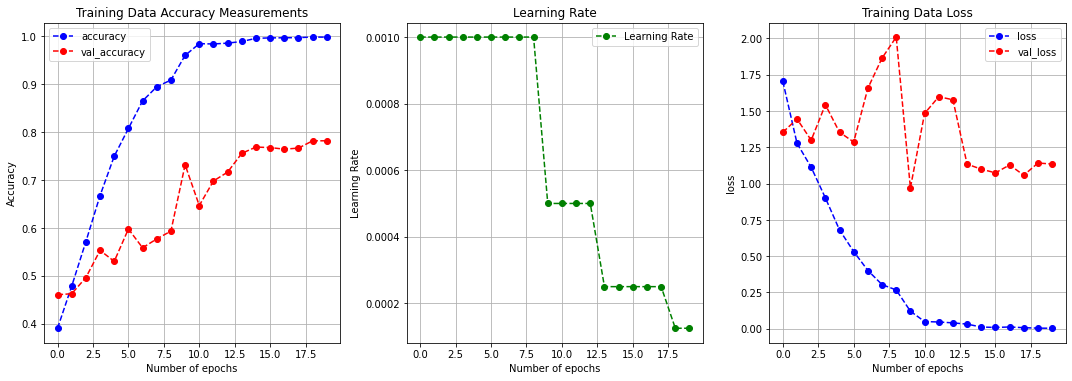

In [ ]:
accuracy_lr_loss_plot(history)

In [ ]:
X_testloss = model.evaluate(X_test, y_test, verbose=1)

34/34 [==============================] - 9s 264ms/step - loss: 0.9500 - accuracy: 0.8026


In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_new = np.argmax(y_test, axis=1)

34/34 [==============================] - 12s 227ms/step


In [ ]:
print(classification_report(y_test_new, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.80      0.85       148
           1       0.87      0.72      0.79        75
           2       0.78      0.64      0.70       176
           3       0.81      0.88      0.85       490
           4       0.72      0.77      0.74       190

    accuracy                           0.80      1079
   macro avg       0.81      0.76      0.79      1079
weighted avg       0.80      0.80      0.80      1079



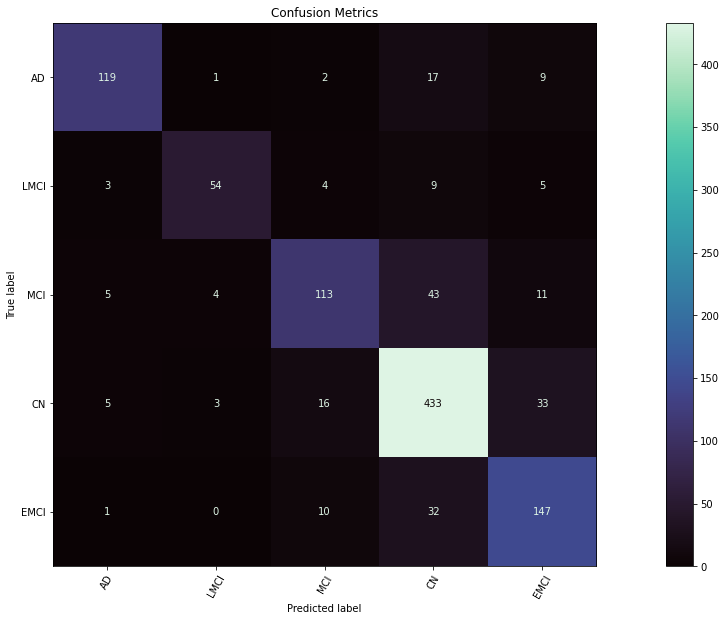

In [ ]:
cm=confusion_matrix(y_test_new, y_pred)
display_c_m = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(25,10)) 
display_c_m.plot(cmap='mako',ax=ax,xticks_rotation=60)
plt.title("Confusion Metrics")
plt.show()